In [164]:
import pandas as pd
import numpy as np
import pybaseball as pb
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

## Introduction

The motivation for this project is entirely due to me being sick of losing at fantasy baseball. For years I routinely have the strongest regular season team, only to fizzle out in the playoffs. Since COVID began, I've been hit especially hard by players sitting out. In past years there's even been (a small amount of) money on the line, so there's financial incentive here. This might all be a pipe dream, but real talk, I'm desperate to win now.

Hopefully a data-driven approach (and a league of managers who probably won't look much deeper than Yahoo's top-level stats) will help me find some sleepers and finally get ahead. I want to look beyond the stats provided to us by Yahoo and see if there's a latent metric I can use to identify players on the rise and pick them up before anyone else. I'll probably be limited by the transaction limit in the league, but if I can sneak an extra 10 points a week with some model, that would put me where I need to be.

I'll keep updating this section as my approach evolves, but the first technique I'd like to attempt is a linear regression without Yahoo's scoring variables. I can perfectly predict a player's Fantasy Points if I know their stats, *but so can everyone else in the league*. What I need is an approach that will allow me to identify something that Yahoo *doesn't* measure that will still be able to predict points.

One last note, as my goal here is just to determine what variables most affect Fantasy Points, there's no need to check model assumptions or get into the guts of the regression. I'm 100% okay with a 'black box' model if it makes good predictions.

## Data
Utilizing the *pybaseball* library, I'll pull the data from the 2018-2021 seasons and use the stats (combined with the scoring settings from our league) to ensure that it lines up with the final results from those seasons. This is a simple step, though not trivial, because if I don't do this and it turns out I'm wrong, and Yahoo has different data than MLB, then this'll never work. I'll create a new field that has the calculated Fantasy Points from Yahoo so I know what the target is. Importantly, the scoring settings have been the same throughout this time period so it's just more data for the regression model.

In [92]:
# Pull pybaseball data (min 10 PAs) from 2020 and 2021 season
batters = pd.DataFrame(pb.batting_stats(2018, 2021, qual=10))

# Calculate fantasy points based on stats, verify it matches Yahoo (it does)
batters["Points"] = (batters["R"]*2 +
                    batters["H"]*1 +
                    batters["2B"]*1 +
                    batters["3B"]*2 +
                    batters["HR"]*3 +
                    batters["RBI"]*2 +
                    batters["SB"]*1 +
                    batters["CS"]*-1 +
                    batters["BB"]*1 +
                    batters["IBB"]*1 +
                    batters["HBP"]*1 +
                    batters["SO"]*-0.5)

In [93]:
batters.sort_values(by='Points', ascending=False)

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,Points
40,15998,2019,Cody Bellinger,LAD,23,156,558,660,170,86,...,110.6,207,0.456,454,0.149,0.246,NaN,NaN,NaN,898.0
34,17678,2019,Alex Bregman,HOU,25,156,554,690,164,84,...,107.4,178,0.372,479,0.204,0.250,NaN,NaN,NaN,888.5
32,19611,2021,Vladimir Guerrero Jr.,TOR,22,161,604,698,188,110,...,117.4,274,0.552,496,0.127,0.250,NaN,NaN,NaN,878.0
47,12861,2019,Anthony Rendon,WSN,29,146,545,646,174,93,...,107.7,215,0.459,468,0.172,0.223,NaN,NaN,NaN,873.0
106,13510,2018,Jose Ramirez,CLE,25,157,578,698,156,75,...,110.2,174,0.345,504,0.184,0.232,NaN,NaN,NaN,866.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,3284,2018,Anibal Sanchez,ATL,34,25,41,44,1,1,...,95.6,1,0.056,18,0.281,0.523,NaN,NaN,NaN,-10.5
2688,3137,2021,Max Scherzer,- - -,36,30,59,63,0,0,...,109.6,8,0.229,35,0.211,0.362,NaN,NaN,NaN,-12.0
2627,19320,2019,Joey Lucchesi,SDP,26,30,48,54,3,3,...,98.7,2,0.118,17,0.319,0.502,NaN,NaN,NaN,-12.0
2675,1994,2018,Ivan Nova,PIT,31,29,53,56,1,1,...,101.4,3,0.115,26,0.249,0.455,NaN,NaN,NaN,-12.0


Yeah everything checks out. That lines up perfectly with Yahoo's numbers, and because we're looking at a regression, there shouldn't be any concern about having fewer games in 2020, as everyone had fewer points too.

Next up is to remove the variables used for points in the league. Why? Well I know *exactly* how much a hit is worth, or a steal, or whatever else, so regression is not required, it's just simple algebra with zero variation. The goal is determine a *latent* variable (more on that later), so using scoring variables to perfectly predict a player's total points is of no value to me.

In [225]:
# Drop Yahoo columns
batters_red = batters.drop(['R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'IBB', 'HBP', 'SO'], axis=1)
batters_red.sample(10)

,IDfg,Season,Name,Team,Age,G,AB,PA,1B,SF,...,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,Points
515,19252,2019,Cavan Biggio,TOR,24,100,354,430,48,2,...,104.6,93,0.397,234,0.210,0.296,NaN,NaN,NaN,405.5
1227,10807,2018,Tyler Saladino,- - -,28,58,126,139,22,1,...,109.3,38,0.432,88,0.231,0.351,NaN,NaN,NaN,97.5
2396,12970,2018,Joe Musgrove,PIT,25,20,31,35,4,0,...,101.8,6,0.261,23,0.182,0.327,NaN,NaN,NaN,4.0
675,10816,2018,Jedd Gyorko,STL,29,125,351,402,61,4,...,107.7,87,0.313,278,0.168,0.281,NaN,NaN,NaN,348.5
2691,6895,2021,Chase Anderson,PHI,33,14,11,14,0,0,...,103.2,1,0.125,8,0.186,0.465,NaN,NaN,NaN,-3.0
1804,13369,2020,Erik Gonzalez,PIT,28,50,181,193,24,3,...,111.4,59,0.440,134,0.135,0.295,NaN,NaN,NaN,114.5
2285,18872,2021,Jahmai Jones,BAL,23,26,67,72,7,0,...,107.4,11,0.268,41,0.210,0.301,NaN,NaN,NaN,22.0
2642,15351,2019,Frank Schwindel,KCR,27,6,15,15,1,0,...,103.3,3,0.231,13,0.082,0.163,NaN,NaN,NaN,0.0
187,18373,2020,Ryan Mountcastle,BAL,23,35,126,140,32,2,...,108.2,41,0.418,98,0.092,0.254,NaN,NaN,NaN,128.0
790,10348,2019,Domingo Santana,SEA,26,121,451,507,72,2,...,109.5,118,0.405,291,0.157,0.298,NaN,NaN,NaN,439.0


308 columns! Wow that's a lot of data. Let's see how many are missing data points, as I suspect it's many, as there will inevitably be some pitching stats stuck in here as well:

,column_name,percent_missing
xwOBA,xwOBA,100.0
xSLG,xSLG,100.0
xBA,xBA,100.0
Pace,Pace,100.0
PO%,PO%,100.0
...,...,...
Z-Contact%,Z-Contact%,0.0
Contact%,Contact%,0.0
Zone%,Zone%,0.0
F-Strike%,F-Strike%,0.0


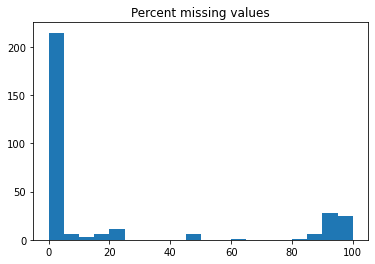

In [226]:
# Calculate % NaN, plot histogram
percent_missing = batters_red.isnull().sum() * 100 / len(batters_red)
missing_value_df = pd.DataFrame({'column_name': batters_red.columns, 'percent_missing': percent_missing})
display(missing_value_df.sort_values(by='percent_missing', ascending=False))
plt.hist(missing_value_df['percent_missing'], bins=20)
plt.title('Percent missing values')
plt.show()

Well there's a ton that have close to no data in them in seems. I think it's safe to remove all columns that are missing >40% of their values

In [227]:
missing_value_cols = missing_value_df[missing_value_df['percent_missing']>40]['column_name']
batters_red.drop(missing_value_cols, axis=1, inplace=True)
display(batters_red)

,IDfg,Season,Name,Team,Age,G,AB,PA,1B,SF,...,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,Points
11,13611,2018,Mookie Betts,BOS,25,136,520,614,96,5,...,18.5,57,0.131,110.6,217,0.500,434,0.220,0.270,826.5
14,10155,2018,Mike Trout,LAA,26,140,471,608,80,4,...,18.5,54,0.153,118.0,161,0.457,352,0.201,0.261,773.0
19,10155,2019,Mike Trout,LAA,27,134,470,600,63,4,...,22.2,62,0.175,116.6,155,0.438,354,0.193,0.258,820.0
34,17678,2019,Alex Bregman,HOU,25,156,554,690,84,8,...,19.6,22,0.046,107.4,178,0.372,479,0.204,0.250,888.5
106,13510,2018,Jose Ramirez,CLE,25,157,578,698,75,6,...,19.0,35,0.069,110.2,174,0.345,504,0.184,0.232,866.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2265,17023,2018,Magneuris Sierra,MIA,22,54,147,156,25,0,...,2.9,0,0.000,104.7,16,0.144,111,0.151,0.261,53.5
1550,393,2018,Victor Martinez,DET,39,133,467,508,87,7,...,14.1,18,0.042,107.6,129,0.304,425,0.148,0.212,350.5
2205,14352,2019,Lewis Brinson,MIA,25,75,226,248,29,1,...,10.0,6,0.039,112.1,51,0.329,155,0.133,0.292,93.0
2271,3448,2019,Jeff Mathis,TEX,36,88,228,244,25,1,...,16.9,1,0.007,105.5,37,0.261,142,0.155,0.322,82.5


Choosing the next round of features to drop might be a bit trickier. We can do some quick correlations to identify indicators that are built to do exactly this, as well as potentially identify a few valuable measures

## Correlations
Next I'll see which variables available from MLB correlate the most with these Fantasy Points. Because I know *exactly* which variables Yahoo uses to calculate our Fantasy Points, I expect that they'll be included here. Certainly they'll give me a problem with regression later, but we'll cross that bridge when we get to it. From these correlations, I've taken the top 30 positively correlated stats (as they all had very high *r* values) and the top 10 negatively correlated. They'll probably fall out in regression selection later if they're no good.

In [228]:
# Calculate the stats that most highly correlate with Fantasy Points
corrs = batters_red.corr()['Points']
corrs = corrs.sort_values(ascending=False)
corrs.head(30)

Points     1.000000
wRC        0.991180
+WPA       0.986090
Rep        0.971707
HardHit    0.971489
PA         0.970714
Pitches    0.968931
AB         0.964951
Strikes    0.964944
Balls      0.964277
Events     0.957671
FB         0.956102
LD         0.937435
1B         0.921832
G          0.919735
GB         0.909180
Barrels    0.895094
RAR        0.816445
WAR        0.816426
IFH        0.783631
GDP        0.779504
IFFB       0.757748
SF         0.733914
wRAA       0.664666
REW        0.650925
RE24       0.650707
Lg         0.641456
wFB        0.629751
WPA/LI     0.625924
SLG        0.620725
Name: Points, dtype: float64

We of course expect `Points` to have a perfect correlation with `Points`, but there are a few other features near the top here that we can use our deep baseball knowledge to inform about their removal. For example, `wRC` is an indicator designed to do...exactly what we're attempting to do, but probably using the variables we've already removed. This next step will remove that and a few others that are either direct measures of a batter's PAs (`PA`), or indirectly related to that. Not shown here was the same process with negatively correlated values, but there were really only two that definitely needed to be removed (`-WPA` and `Pos`), along with columns for player name, team, and league.

(these were mostly decoded using Fangraphs https://library.fangraphs.com/offense/offensive-statistics-list/)

In [229]:
to_remove = ['wRC', 
             '+WPA', 
             'Rep', 
             'PA', 
             'Pitches', 
             'AB', 
             'Strikes', 
             'Balls', 
             'Events', 
             'FB', 
             'LD', 
             '1B', 
             'G', 
             'RAR',
             'WAR',
             'REW',
             '-WPA', 
             'Pos',
             'IDfg',
             'Season',
             'Name',
             'Team',
             'Lg',
             'Dol',
             'Age Rng']
batters_red2 = batters_red.drop(to_remove, axis=1)
batters_red2

,Age,SF,SH,GDP,AVG,GB,IFFB,IFH,BU,BUH,...,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,CStr%,CSW%,Points
11,25,5,0,5,0.346,147,18,14,0,0,...,92.3,18.5,57,0.131,110.6,217,0.500,0.220,0.270,826.5
14,26,4,0,5,0.312,110,15,11,0,0,...,91.2,18.5,54,0.153,118.0,161,0.457,0.201,0.261,773.0
19,27,4,0,5,0.291,86,17,10,0,0,...,90.9,22.2,62,0.175,116.6,155,0.438,0.193,0.258,820.0
34,25,8,0,9,0.296,151,26,3,0,0,...,89.3,19.6,22,0.046,107.4,178,0.372,0.204,0.250,888.5
106,25,6,0,2,0.270,168,30,13,1,0,...,89.0,19.0,35,0.069,110.2,174,0.345,0.184,0.232,866.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2265,22,0,3,0,0.190,54,4,11,17,5,...,83.6,2.9,0,0.000,104.7,16,0.144,0.151,0.261,53.5
1550,39,7,0,19,0.251,167,15,6,1,1,...,87.8,14.1,18,0.042,107.6,129,0.304,0.148,0.212,350.5
2205,25,1,2,8,0.173,75,5,5,3,0,...,87.0,10.0,6,0.039,112.1,51,0.329,0.133,0.292,93.0
2271,36,1,0,2,0.158,55,10,3,3,1,...,86.1,16.9,1,0.007,105.5,37,0.261,0.155,0.322,82.5


## Imputation

Before we can proceed to regression, we have to handle our NaN values. We can use Scikit-Learn for this, imputing with the median values seems appropriate:

In [230]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
batters_imp = pd.DataFrame(imp.fit_transform(batters_red2), columns=batters_red2.columns.values)
batters_imp

,Age,SF,SH,GDP,AVG,GB,IFFB,IFH,BU,BUH,...,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,CStr%,CSW%,Points
0,25.0,5.0,0.0,5.0,0.346,147.0,18.0,14.0,0.0,0.0,...,92.3,18.5,57.0,0.131,110.6,217.0,0.500,0.220,0.270,826.5
1,26.0,4.0,0.0,5.0,0.312,110.0,15.0,11.0,0.0,0.0,...,91.2,18.5,54.0,0.153,118.0,161.0,0.457,0.201,0.261,773.0
2,27.0,4.0,0.0,5.0,0.291,86.0,17.0,10.0,0.0,0.0,...,90.9,22.2,62.0,0.175,116.6,155.0,0.438,0.193,0.258,820.0
3,25.0,8.0,0.0,9.0,0.296,151.0,26.0,3.0,0.0,0.0,...,89.3,19.6,22.0,0.046,107.4,178.0,0.372,0.204,0.250,888.5
4,25.0,6.0,0.0,2.0,0.270,168.0,30.0,13.0,1.0,0.0,...,89.0,19.0,35.0,0.069,110.2,174.0,0.345,0.184,0.232,866.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,22.0,0.0,3.0,0.0,0.190,54.0,4.0,11.0,17.0,5.0,...,83.6,2.9,0.0,0.000,104.7,16.0,0.144,0.151,0.261,53.5
2696,39.0,7.0,0.0,19.0,0.251,167.0,15.0,6.0,1.0,1.0,...,87.8,14.1,18.0,0.042,107.6,129.0,0.304,0.148,0.212,350.5
2697,25.0,1.0,2.0,8.0,0.173,75.0,5.0,5.0,3.0,0.0,...,87.0,10.0,6.0,0.039,112.1,51.0,0.329,0.133,0.292,93.0
2698,36.0,1.0,0.0,2.0,0.158,55.0,10.0,3.0,3.0,1.0,...,86.1,16.9,1.0,0.007,105.5,37.0,0.261,0.155,0.322,82.5


## Scaling

As we ultimately want to judge the relative importance of each feature, we'll also need to scale everything:

In [231]:
scaler = StandardScaler()
batters_final = pd.DataFrame(scaler.fit_transform(batters_imp), columns=batters_red2.columns.values)
batters_final

,Age,SF,SH,GDP,AVG,GB,IFFB,IFH,BU,BUH,...,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,CStr%,CSW%,Points
0,-0.766380,1.806763,-0.502630,0.163213,1.832288,1.325565,1.984496,1.912833,-0.608903,-0.397520,...,1.346851,0.881475,3.405372,1.483550,0.540411,2.774871,1.413854,0.921682,-0.490317,3.122118
1,-0.495326,1.297550,-0.502630,0.163213,1.355376,0.725297,1.510184,1.314773,-0.608903,-0.397520,...,1.039015,0.881475,3.184027,1.932574,1.956038,1.805116,1.058232,0.521544,-0.644684,2.858160
2,-0.224272,1.297550,-0.502630,0.163213,1.060813,0.335934,1.826392,1.115420,-0.608903,-0.397520,...,0.955060,1.299072,3.774279,2.381598,1.688216,1.701214,0.901097,0.353065,-0.696140,3.090049
3,-0.766380,3.334401,-0.502630,1.015998,1.130947,1.390459,3.249326,-0.280055,-0.608903,-0.397520,...,0.507298,1.005626,0.823019,-0.251318,-0.071752,2.099506,0.355260,0.584724,-0.833355,3.428014
4,-0.766380,2.315975,-0.502630,-0.476375,0.766249,1.666258,3.881742,1.713480,-0.304226,-0.397520,...,0.423342,0.937907,1.782178,0.218117,0.463891,2.030238,0.131963,0.163526,-1.142090,3.317003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,-1.579542,-0.739302,1.226896,-0.902767,-0.355897,-0.183217,-0.228958,1.314773,4.570609,3.838096,...,-1.087854,-0.879201,-0.800174,-1.190187,-0.588264,-0.705856,-1.530360,-0.531450,-0.644684,-0.691708
2696,3.028375,2.825188,-0.502630,3.147958,0.499740,1.650034,1.510184,0.318006,-0.304226,0.449603,...,0.087521,0.384874,0.527893,-0.332958,-0.033492,1.250971,-0.207118,-0.594630,-1.485129,0.773630
2697,-0.766380,-0.230089,0.650387,0.802802,-0.594353,0.157476,-0.070854,0.118652,0.305129,-0.397520,...,-0.136360,-0.077868,-0.357485,-0.394189,0.827362,-0.099759,-0.000361,-0.910528,-0.112974,-0.496822
2698,2.215214,-0.230089,-0.502630,-0.476375,-0.804756,-0.166994,0.719665,-0.280055,0.305129,0.449603,...,-0.388226,0.700893,-0.726393,-1.047316,-0.435224,-0.342198,-0.562739,-0.447211,0.401584,-0.548627


## Regression
Without further ado, let's toss this into a regression model and see what happens!

In [232]:
reg = LinearRegression()
reg.fit(batters_final[batters_final.columns[:-1]], batters_final['Points'])
batters_coefs = pd.DataFrame(reg.coef_).T
batters_coefs.columns = batters_final.columns[:-1]
batters_coefs

,Age,SF,SH,GDP,AVG,GB,IFFB,IFH,BU,BUH,...,Hard%+,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,CStr%,CSW%
0,-0.001913,0.044288,-0.014823,0.115107,-0.211428,0.344284,0.082812,-0.013012,0.030779,0.002477,...,-0.036703,-0.021487,0.012095,0.183185,-0.046159,-0.000965,0.171402,-0.013388,-0.23371,0.288384


So now we have a vector of regression coefficients, and since they've been scaled we should be able to use their values as their relative importance. We'll transpose and look at the top 10 values for estimating `Points`:

In [233]:
batters_coefs.T.sort_values(by=0, ascending=False).head(10)

,0
Pull%,1.237790
SLG,1.083435
Cent%,0.870132
Oppo%,0.718565
OBP,0.391708
Off,0.387632
GB%,0.352583
TTO%,0.351266
wRAA,0.346542
GB,0.344284


Interesting that all three measures of spread (`Pull%`, `Cent%`, and `Oppo%`) are all included in the top 10 here. Apparently it doesn't seem to matter where you hit the ball. It's common knowledge that a pull hitter will usually put more power on the ball, so that's maybe not too surprising that it's the most important feature, especially with `SLG` being at the top as well. I long suspected that sluggers were the most important type of player to have in our league, this data really backs it up. Seeing `TTO%` in there as well further solidies that argument.

I'll put a pause on working on this model for a short while, but I think I have enough information to take a look at Spring Training and help guide my draft strategy